<a href="https://colab.research.google.com/github/maggiecope/comp351-ai-project/blob/main/Comp351FinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
# STEP 1: Import Libraries and load dataset

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Load your dataset
df = pd.read_csv("Wait_Times.csv")

# Preview the data
df.head()

,Land,Ride,Wait Time,Local Time,Day of Week,Date,tempmax,tempmin,temp,humidity,...,visibility,solarradiation,solarenergy,uvindex,severerisk,sunrise,sunset,moonphase,conditions,description
0,Pixar Pier,Toy Story Midway Mania!,40,2024-09-23 17:30:04,Monday,2024-09-23,78.4,62.4,67.9,80.5,...,5.6,210.0,18.0,8,10,2024-09-23 6:40:56,2024-09-23 18:46:15,0.69,Partially cloudy,Clearing in the afternoon.
1,Cars Land,Mater's Graveyard JamBOOree,30,2024-09-23 17:45:03,Monday,2024-09-23,78.4,62.4,67.9,80.5,...,5.6,210.0,18.0,8,10,2024-09-23 6:40:56,2024-09-23 18:46:15,0.69,Partially cloudy,Clearing in the afternoon.
2,Hollywood Land,Mickey's PhilharMagic,10,2024-09-23 17:45:03,Monday,2024-09-23,78.4,62.4,67.9,80.5,...,5.6,210.0,18.0,8,10,2024-09-23 6:40:56,2024-09-23 18:46:15,0.69,Partially cloudy,Clearing in the afternoon.
3,Pixar Pier,Jumpin' Jellyfish,20,2024-09-23 17:45:03,Monday,2024-09-23,78.4,62.4,67.9,80.5,...,5.6,210.0,18.0,8,10,2024-09-23 6:40:56,2024-09-23 18:46:15,0.69,Partially cloudy,Clearing in the afternoon.
4,Avengers Campus,WEB SLINGERS: A Spider-Man Adventure,45,2024-09-23 18:00:04,Monday,2024-09-23,78.4,62.4,67.9,80.5,...,5.6,210.0,18.0,8,10,2024-09-23 6:40:56,2024-09-23 18:46:15,0.69,Partially cloudy,Clearing in the afternoon.


In [2]:
#STEP 2: Clean and Convert

# Convert timestamp columns to datetime
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
df["Local Time"] = pd.to_datetime(df["Local Time"], errors="coerce")
df["sunrise"] = pd.to_datetime(df["sunrise"], errors="coerce")
df["sunset"] = pd.to_datetime(df["sunset"], errors="coerce")

# Engineer numeric time features
df["hour"] = df["Local Time"].dt.hour
df["minute"] = df["Local Time"].dt.minute
df["time_in_minutes"] = df["hour"] * 60 + df["minute"]
df["day_of_week_num"] = df["Date"].dt.weekday      # 0=Mon, 6=Sun
df["day_of_year"] = df["Date"].dt.dayofyear
df["month"] = df["Date"].dt.month

# Quick preview of engineered time fields
df[["Date", "Local Time", "hour", "minute", "time_in_minutes",
    "day_of_week_num", "day_of_year", "month"]].head()

,Date,Local Time,hour,minute,time_in_minutes,day_of_week_num,day_of_year,month
0,2024-09-23,2024-09-23 17:30:04,17,30,1050,0,267,9
1,2024-09-23,2024-09-23 17:45:03,17,45,1065,0,267,9
2,2024-09-23,2024-09-23 17:45:03,17,45,1065,0,267,9
3,2024-09-23,2024-09-23 17:45:03,17,45,1065,0,267,9
4,2024-09-23,2024-09-23 18:00:04,18,0,1080,0,267,9


In [3]:
# STEP 3: Drop unusable columns and one-hot encode categoricals (KNN Model)

# Columns that cannot be used directly by KNN
drop_cols = ["Local Time", "Date", "sunrise", "sunset", "description"]

# Drop only if they exist in df
drop_cols = [c for c in drop_cols if c in df.columns]
df = df.drop(columns=drop_cols)

# One-hot encode ALL categorical variables at once
df_encoded = pd.get_dummies(df, drop_first=True)

# Confirm all features are numeric now
df_encoded.dtypes.head(20)


Wait Time             int64
tempmax             float64
tempmin             float64
temp                float64
humidity            float64
precip              float64
windgust            float64
windspeed           float64
winddir             float64
sealevelpressure    float64
cloudcover          float64
visibility          float64
solarradiation      float64
solarenergy         float64
uvindex               int64
severerisk            int64
moonphase           float64
hour                  int32
minute                int32
time_in_minutes       int32
dtype: object

In [4]:
# STEP 4: Train-test split and scale features (KNN Model)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Separate features (X) and target (y)
X = df_encoded.drop(columns=["Wait Time"])
y = df_encoded["Wait Time"]

# Train/test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Scale all numeric features for KNN
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Show shapes to confirm
X_train_scaled.shape, X_test_scaled.shape


((271251, 66), (67813, 66))

In [5]:
# STEP 5: Fit KNN model and evaluate performance

from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Create KNN regressor with k = 5 neighbors (you can tune this later)
knn = KNeighborsRegressor(n_neighbors=5)

# Fit on the scaled training data
knn.fit(X_train_scaled, y_train)

# Predict on train and test sets
y_pred_train_knn = knn.predict(X_train_scaled)
y_pred_test_knn = knn.predict(X_test_scaled)

# Compute metrics
train_rmse_knn = np.sqrt(mean_squared_error(y_train, y_pred_train_knn))
test_rmse_knn = np.sqrt(mean_squared_error(y_test, y_pred_test_knn))
train_r2_knn = r2_score(y_train, y_pred_train_knn)
test_r2_knn = r2_score(y_test, y_pred_test_knn)

(train_rmse_knn, test_rmse_knn, train_r2_knn, test_r2_knn)


(np.float64(9.520185516154655),
 np.float64(11.43796373002186),
 0.8504088201266804,
 0.7813849782115716)

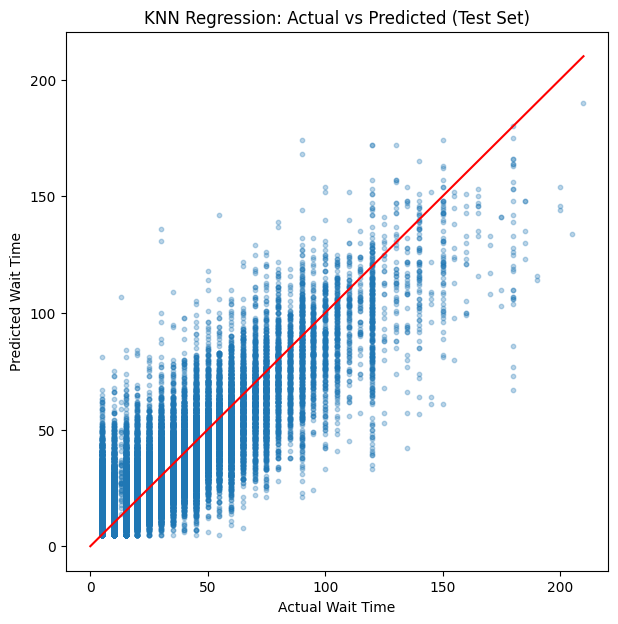

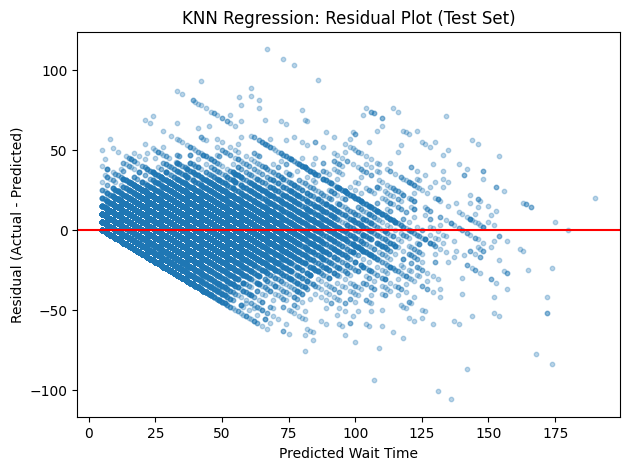

In [6]:
# STEP 6: Visualize KNN predictions (Actual vs Predicted + Residuals)

import matplotlib.pyplot as plt

# --- 1. Actual vs Predicted ---
plt.figure(figsize=(7,7))
plt.scatter(y_test, y_pred_test_knn, alpha=0.3, s=10)
plt.xlabel("Actual Wait Time")
plt.ylabel("Predicted Wait Time")
plt.title("KNN Regression: Actual vs Predicted (Test Set)")
plt.plot([0, max(y_test)], [0, max(y_test)], color="red")   # perfect prediction line
plt.show()

# --- 2. Residual Plot ---
residuals_knn = y_test - y_pred_test_knn

plt.figure(figsize=(7,5))
plt.scatter(y_pred_test_knn, residuals_knn, alpha=0.3, s=10)
plt.axhline(0, color="red")
plt.xlabel("Predicted Wait Time")
plt.ylabel("Residual (Actual - Predicted)")
plt.title("KNN Regression: Residual Plot (Test Set)")
plt.show()


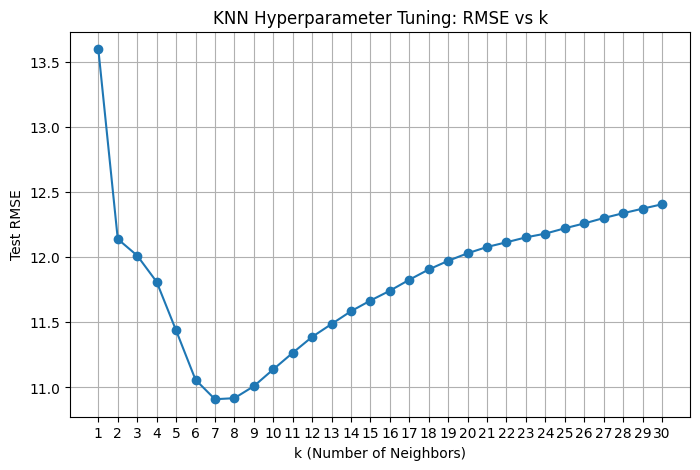

In [ ]:
# STEP 7: Tune k (number of neighbors) for KNN Regression

import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

k_values = range(1, 31)
rmse_values = []

for k in k_values:
    knn_k = KNeighborsRegressor(n_neighbors=k)
    knn_k.fit(X_train_scaled, y_train)
    y_pred_k = knn_k.predict(X_test_scaled)
    rmse_k = np.sqrt(mean_squared_error(y_test, y_pred_k))
    rmse_values.append(rmse_k)

# Plot RMSE vs k
plt.figure(figsize=(8,5))
plt.plot(k_values, rmse_values, marker='o')
plt.xticks(k_values)
plt.xlabel("k (Number of Neighbors)")
plt.ylabel("Test RMSE")
plt.title("KNN Hyperparameter Tuning: RMSE vs k")
plt.grid(True)
plt.show()


In [11]:
# STEP 8: Final KNN model using k = 7

from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# 1. Fit KNN with optimal k = 7
knn_best = KNeighborsRegressor(n_neighbors=8)
knn_best.fit(X_train_scaled, y_train)

# 2. Predictions
y_pred_train_knn_best = knn_best.predict(X_train_scaled)
y_pred_test_knn_best = knn_best.predict(X_test_scaled)

# 3. Metrics
train_rmse_knn_best = np.sqrt(mean_squared_error(y_train, y_pred_train_knn_best))
test_rmse_knn_best = np.sqrt(mean_squared_error(y_test, y_pred_test_knn_best))
train_r2_knn_best = r2_score(y_train, y_pred_train_knn_best)
test_r2_knn_best = r2_score(y_test, y_pred_test_knn_best)

print("Final KNN Model (k = 7) Performance:")
print(f"Train RMSE: {train_rmse_knn_best:.4f}")
print(f"Test RMSE:  {test_rmse_knn_best:.4f}")
print(f"Train R²:   {train_r2_knn_best:.4f}")
print(f"Test R²:    {test_r2_knn_best:.4f}")


# Final Numebrs got Final KNN Model (k = 7) Performance:
#Train RMSE: 9.5459
#Test RMSE:  10.9097
#Train R²:   0.8496
#Test R²:    0.8011



Final KNN Model (k = 7) Performance:
Train RMSE: 9.6157
Test RMSE:  10.9177
Train R²:   0.8474
Test R²:    0.8008
